В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [23]:
import opendatasets as od
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/data'
od.download(dataset_url)
data_dir = './bank-customer-churn-prediction-dlu'
train_csv = data_dir + '/train.csv'
test_csv = data_dir + '/test.csv'
sample_submission = data_dir + '/sample_submission.csv'


Skipping, found downloaded files in ".\bank-customer-churn-prediction-dlu" (use force=True to force download)


Area under ROC score on  dataset: 0.93%


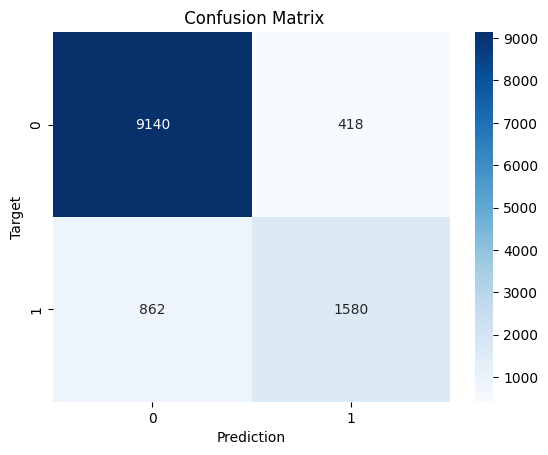

Area under ROC score on  dataset: 0.93%


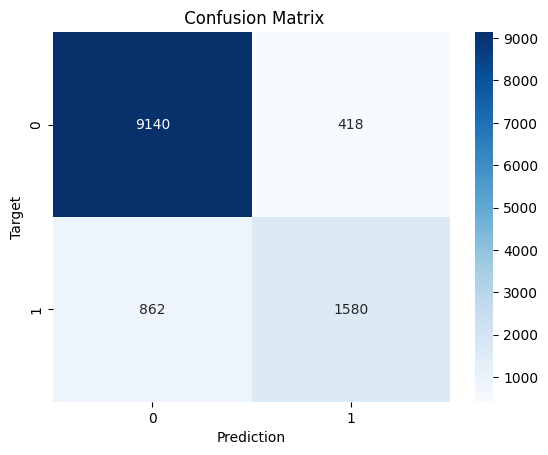

['log_reg.joblib']

In [30]:
train_df = pd.read_csv(train_csv)

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = train_df[input_cols].copy()
val_targets = train_df[target_col].copy()

# Виявляємо числові і категоріальні колонки
numeric_cols = [
 'Age',
 'Balance',
 'CreditScore',
 'IsActiveMember',
 'EstimatedSalary']
categorical_cols = ['Geography', 'Gender','NumOfProducts' ]

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler(feature_range=(0, 1)))
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict_proba(inputs)[:, 1]
    fpr, tpr, thresholds = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    preds_for_matrix = model_pipeline.predict(inputs)
    confusion_matrix_ = confusion_matrix(targets, preds_for_matrix)
    plt.figure()
    sns.heatmap(confusion_matrix_, fmt='d', annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets )
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets)

# Зберігаємо модель для подальшого використання
import joblib

joblib.dump(model_pipeline, 'log_reg.joblib')


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on  dataset: 0.93%


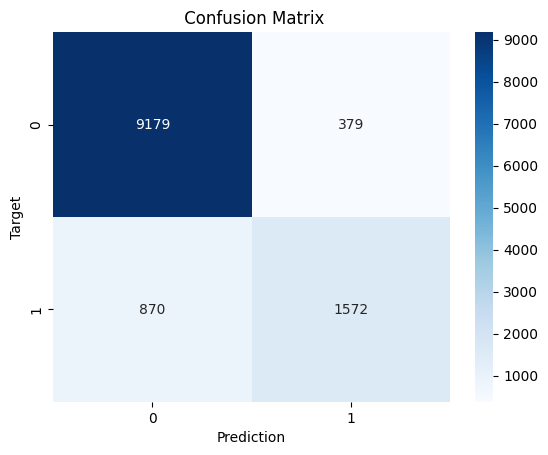

Area under ROC score on  dataset: 0.93%


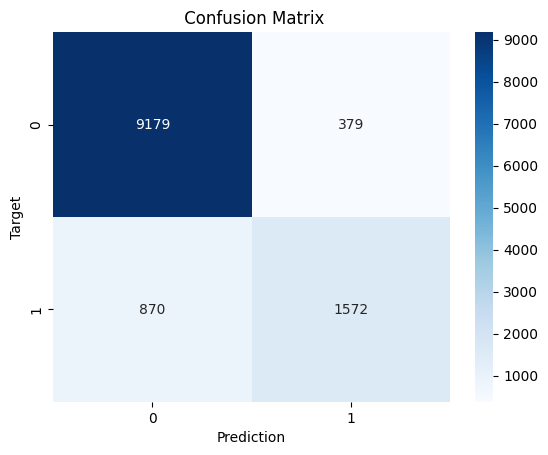

In [33]:
import operator
from sklearn.preprocessing import PolynomialFeatures

numeric_transformer = Pipeline(steps=[
    ('polynomial', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', MinMaxScaler(feature_range=(0, 1)))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_pipeline.fit(train_inputs, train_targets)

train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets )
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets)

**Спостереження** Ця модель добре генералізує і недо чи перенавчання не спостерігається

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on  dataset: 0.93%


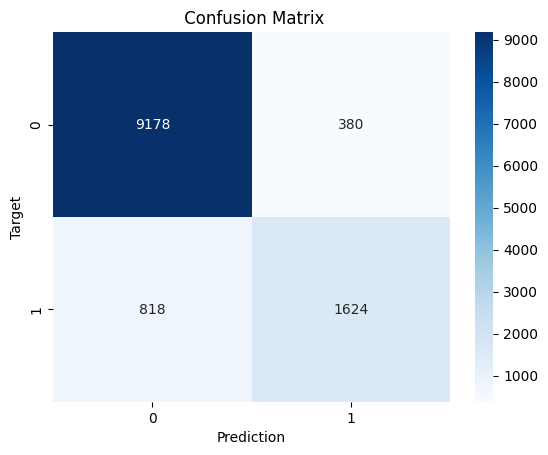

Area under ROC score on  dataset: 0.93%


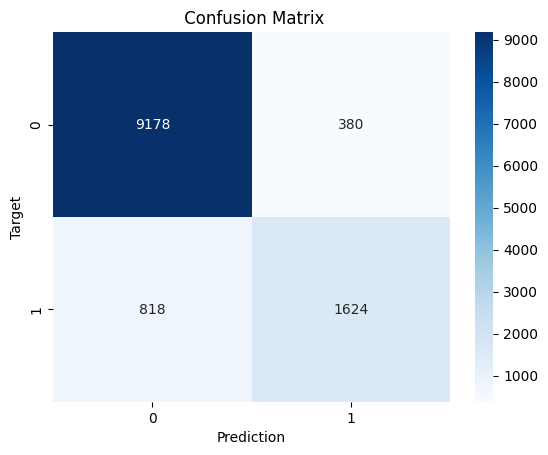

In [34]:
numeric_transformer = Pipeline(steps=[
    ('polynomial', PolynomialFeatures(degree=4, include_bias=False)),
    ('scaler', MinMaxScaler(feature_range=(0, 1)))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

model_pipeline.fit(train_inputs, train_targets)

train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets )
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets)

**Спостереження** Дана модель дає кращі результати ніж всі попередні, тому я засабмітила її у змаганні і ця модель дала найкращий скор з усіх, що в мене були

In [35]:
test_raw_df = pd.read_csv(test_csv)

In [38]:
import warnings
warnings.filterwarnings("ignore")
def predict_test(model_pipeline, inputs):
    preds = model_pipeline.predict_proba(inputs)[:, 1]
    return preds


test_raw_df = pd.read_csv(test_csv)
test_raw_df['Exited'] = predict_test(model_pipeline, test_raw_df)
sample_submission = pd.read_csv(sample_submission)
merged_df = sample_submission.merge(test_raw_df, on='id', how='left')
merged_df['Exited'] = merged_df['Exited_y']
merged_df = merged_df[['id', 'Exited']]

In [39]:
merged_df.to_csv('submission_log_reg9.csv', index=False)

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [45]:
regression_data = pd.read_csv('./regression_data.csv')
X = regression_data.drop(['target'], axis=1)
y = regression_data['target']

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('polynomial', PolynomialFeatures(degree=5, include_bias=False)),
    ('classifier', LinearRegression())  
])

# Тренуємо пайплайн
pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train) 
y_pred_test = pipeline.predict(X_test) 
print('Train RMSE: ', mean_squared_error(y_train, y_pred_train, squared=False))
print('Test RMSE: ', mean_squared_error(y_test, y_pred_test, squared=False))


Train RMSE:  4.185065450800518e-13
Test RMSE:  35.62805277364292


**Спостереження** Модель погано генералізує, Дуже маленька помилка на тренувальних даних і велика помилка на тестувальних даних: спостерігаємо перенавчання, так як помилка на тренувальних даних дуже мала, це означає, що модель занадно точно описує дані

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [53]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
models = [
    Lasso(),
    Ridge(),
    ElasticNet(),
]

poly_features = PolynomialFeatures(degree=20)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_metrics = mean_squared_error(y_train, y_train_pred, squared=False).round(6)
    test_metrics = mean_squared_error(y_test, y_test_pred, squared=False).round(6)

    return dict(train=train_metrics, test=test_metrics)
    
for model in models:
    model.fit(X_train_poly, y_train)
    eval_results  = evaluate_model(model, X_train_poly, y_train, X_test_poly, y_test)
    print(f'{str(model)}: {eval_results}\n')

Lasso(): {'train': 2.313505, 'test': 68.318791}

Ridge(): {'train': 32.545075, 'test': 9822.337562}

ElasticNet(): {'train': 10.159852, 'test': 1526.820921}



**Спостереження** Перша модель з регулязізацією Лассо виглядає як недонавчена. Дві іншу моделі - перенавчені. З усіх цих моделей я б обрала Лассо, так як вона генералізує трішки краще ніж інші.